# VQLS tutorial Classic vs Quantum

This tutorial will explain how to solve a linear partial differential equation (PDE) using a variational quantum linear solver (VQLS) via an example. For this example, we will use the heat equation PDE, as it is the most widely discussed PDE at Dutch universities. First, the heat equation will be modified and solved using classical and quantum methods. The two results will then be compared for further analysis.

This tutorial assumes an intermediate understanding of quantum mechanics and computing. Some of the mathematical deviations and computing techniques will not make sense to those who have not fulfilled these requirements. Further research is needed for some students.

# Imports

This tutorial will use a commonly used quantum software development kit called: Pennylane (version 0.43.1). Numpy (version 2.3.5) and Matplotlib (version 3.10.7) are also required. Make sure you have installed these packages before starting the tutorial. If they are installed correctly, these imports should run:

In [32]:
# Importing
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# Example using heat equation PDE

## Chosen equation

We start with the PDE that we want to solve. For this example, we start with the heat equation:
$$
\frac{\partial T}{\partial t}=\alpha \frac{\partial^2 T}{\partial x^2}
$$

Where $T$ is the temperature, $t$ is the time, $\alpha$ is the thermal diffusivity and $x$ is the position. The value of $\alpha$ depends on the properties of the material whose temperature you want to measure:
$$
\alpha = \frac{\kappa}{c\rho}
$$
Since these properties do not depend on time or position, we can leave out the thermal conductivity ($\kappa$), heat capacity ($c$) and density ($\rho$). For now, at least.

# Preconditions

Let’s establish the preconditions of our little example. Our example contains a copper wire of length $L$ and initial temperature $T_{initial}$, which is heated, by temperature $T_h$, and cooled, by temperature $T_c$, on opposite sides of the wire. For simplicity, we’ll assume that our wire is infinitely thin and infinitely short. This means that our wire has only one dimension, making it much easier to calculate. For visualisation purposes, our example looks like this:

![Classical result of example](Figures/ExampleSituation.png "Title")

Now, let's determine the constants mentioned earlier in our example:

In [33]:
# Copper wire constant
kappa = 390 # Thermal conductivity in W/mK
c = 380 # Heat capacity in J/kgK
rho = 8960 # Density in kg/m**3
alpha = kappa/(c*rho)

# Temperatures
Tc = 223 # Cold temperature at one end of the wire in Kelvin
Th = 323 # Hot temperature at the other end of the wire in Kelvin
Ti = 273 # Initial temperature of the wire in Kelvin

L = 1 # Length of the wire in m

We'll call the position where the wire is cooled $x=0$ and the position where the wire is heated $x=L$. This creates a difference in length to calculate over. When we measure 8 points along the length of the wire, waiting 10 seconds after applying the temperatures before taking the measurements, the following array and variables are obtained:

In [34]:
# Variables
N = 8 # Amount of points of measurement
t = 10 # Time waited before measuring 

domain = np.linspace(0,L,N) # Array of positions to measure

## Discretization of $x$ and $t$

Suppose we take $N$ measurements, each of which is determined by an index $i=0,1,...,N-1$. When we discretize the space, we obtain the following equation:

$$
\frac{\partial^2T}{\partial x^2} \approx \frac{(T_i-T_{i+1})^2}{{(dx)^2}} = \frac{T_i-2T_{i+1}+T_{i+2}}{(dx)^2}
$$
Where $dx$ is the space step size, which is determined by $dx = L/(N-1)$. Let's calculate the formula for $dx$:

In [35]:
dx = L/(N-1) # Space step size in m

Now, we will also discretize the time using the backward Euler method. The Backward Euler equation is as follows:

$$
\frac{\partial T_i}{\partial t} \approx \frac{T_i^{(n+1)}-T_i^{(n)}}{dt}
$$

Here, $n$ is the time index, determined by $n = 0, 1, ..., N - 1$, and $dt$ is the time step size, determined by $dt = t / t_{step}$. Here, t is the amount of time waited before measuring the whole wire, and $t_{step}$ is the time step for the number of points measured. These parameters will also be determined in our code.

In [36]:
time_step = 0.1 # Time step of the measurements, must be smaller than 1
dt = t/time_step # Time step size in s

Combining the last two equations yields the following:

$$
\frac{T_i^{(n+1)}-T_i^{(n)}}{dt} =\alpha \frac{T_i^{(n+1)} - 2T_{i+1}^{(n+1)}+T_{i+2}^{(n+1)}}{(dx)^2}
$$

## Matrix formulation

Let's introduce the constant $s$. This constant is determined by the following equation:
$$
s = \frac{\alpha dt}{(dx)^2}
$$
With the code: 

In [37]:
s = alpha*dt/dx**2 # s in example matrix A

Introducing $s$ allows us to simplify our equation:
$$
	T_i^{(n+1)}-T_i^{(n)} = s(T_i^{(n+1)} - 2T_{i+1}^{(n+1)}+T_{i+2}^{(n+1)})
$$
This equation can be rewritten as follows:
$$
	T_i^n = (1+2s)T_{i+1}^{(n+1)} - sT_{i}^{(n+1)}-sT_{i+2}^{(n+1)}
$$
This involves isolating all the $T^n$ terms from the $T^{(n+1)}$ terms. This gives matrix $A$ via the equation $A\cdot T^{(n+1)}= T^n$. When this equation is written in matrix form, the following matrix is formed:
$$
	A =
	\begin{pmatrix}
	1 & 0 & 0 & 0 & \cdots & 0 & 0 \\
	-s & 1+2s & -s & 0 & \cdots & 0 & 0 \\
	0 & -s & 1+2s & -s & \cdots & 0 & 0 \\
	\vdots & \vdots & \ddots & \ddots & \ddots & \vdots & \vdots \\
	0 & 0 & \cdots & 0 & -s & 1+2s & -s \\
	0 & 0 & \cdots & 0 & 0 & 0 & 1
	\end{pmatrix}
$$
Matrix $A$ will be an $N\times N$ matrix. Let's recreate matrix $A$ using the following code:

In [38]:
# Recreating matrix A
A = np.zeros((N,N))
for i in range(1,N-1):
    A[i,i-1] = -s
    A[i,i] = 1+2*s
    A[i,i+1] = -s

A[0,0] = 1
A[-1,-1] = 1

Once matrix $A$ has been determined, it is time to determine vector $b$. While $A$ contains information about the time and properties of the wire, $b$ contains details of the initial temperature conditions. It is a simple 1D array expressed as follows: $b=T_c, T_{initial}, T_{initial}, ... , T_{initial}, T_h$. where b has length $N$. This gives us the code:

In [39]:
# Determine matrix b for the heat equation
b = np.zeros(N)
for i in range(len(b)):
    b[i] = Ti
b[0] = Tc
b[-1] = Th

## Results

Now, $A$ and $b$ are in a linear form can be computed using a linear solver. For example, the numpy function $np.linalg.solve()$ from Numpy can be used. This is also how a linear PDE equation is classically solved using matrices. When we compute and print our result, we obtain:

In [40]:
# Solve the linear equation
y_classical = np.linalg.solve(A, b)
print("x_classical=\n",y_classical)

x_classical=
 [223.         258.72151945 269.00328453 272.1641617  273.8358383
 276.99671547 287.27848055 323.        ]


The following plot shows our results:

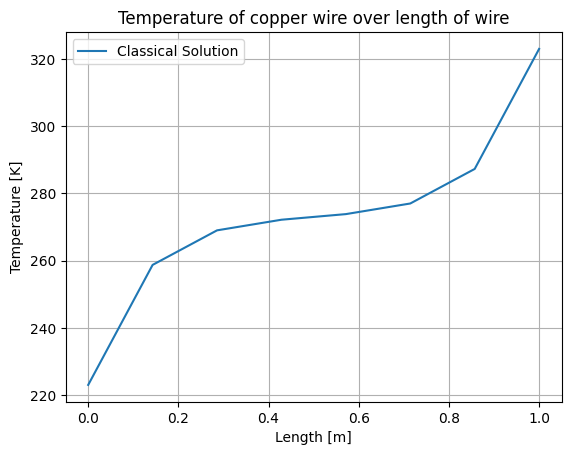

In [41]:
plt.plot(domain,y_classical,label='Classical Solution')
plt.title("Temperature of copper wire over length of wire")
plt.xlabel('Length [m]')
plt.ylabel('Temperature [K]')
plt.legend()
plt.grid()
plt.show()

Of course, this example disregards the thermal effects occurring outside the wire. Therefore, this example is not very realistic.

# Quantum Solution 

## Finding quantum $A$ and $b$

To find the quantum solution, we will create a Variational Quantum Linear Solver (VQLS), which will amplitude-encode our temperatures in a quantum state. The probability amplitudes of these states will therefore represent the temperatures at the end. A common trick during amplitude encoding is to apply Hadamard gates to all qubits in order to represent all possible solutions. During this process, the number of    possible states will increase from 1 state to $2^n$ states. Here, $n$ is the number of qubits in the circuit. In our example we have an $8\times 8$ matrix, so we will need $log_2(8)=3$ qubits. Let's compute this:

In [42]:
n_qubits = np.log2(N)  # Number of system qubits. This tutorial only works with 3 qubits.

# Checks if the number of qubits is a whole number
if n_qubits % 1 != 0:
    raise TypeError("n_qubits must be a whole number")

n_qubits = int(n_qubits) # n_qubits must be an integer

At the end of a quantum simulation, the state is measured. When this happens, the state breaks the superposition. For this reason, multiple measurements are performed during a quantum simulation to provide the most accurate representation of the probability amplitudes of the final state. Let's define the number of measurements:

In [43]:
n_shots = 10 ** 6  # Number of quantum measurements

Now, let's solve the problem with the quantum gates. First, we need to quantify our linear heat equation as follows: $A\ket{x} \approx \ket{b}$ so that it can be solved using a quantum circuit. As $A$ is a linear system, it can be divided into several components. Our use case will determine the combination:
$$
	A = c_0A_0+c_1A_1+c_2A_2+c_3A_3
$$
Here, $A_n$ is part of the full matrix, with $c_n$ as its coefficients. $A_n$ must be represented using quantum gates, but the coefficients of $c_n$ must be determined manually. Matrix $A$ can be recreated with quantum gates using the operators of the quantum gates. For matrix $A$, we find the following combination:
$$
	A = -sX_0-sX_1-sX_2+(1+2s)I
$$
Here $X_n$ is the Pauli-X quantum gate acting on the $n^{th}$ qubit. $I$ is an identity gate which leaves the qubit's state unchanged. The equation shows that the coefficients $c_n = [-s, -s, -s, 1 + 2s]$ are used. Let's compute the coefficients.

In [44]:
c = np.array([-s, -s, -s, 1 + 2*s], dtype=float) # Coefficients of the linear combination

The following matrix can be found when matrix $A$ is computed using linear operators and their coefficients:
$$
	A =
	\begin{pmatrix}
	1+2s & -s & -s & 0 & -s & 0 & 0 & 0 \\
	-s & 1+2s & 0 & -s & 0 & -s & 0 & 0 \\
	-s & 0 & 1+2s & -s & 0 & 0  & -s & 0 \\
	0 & -s & -s & 1+2s & 0 & 0 & 0 & -s \\
	-s & 0 & 0 & 0 & 1+2s & -s  & -s & 0 \\
	0 & -s & 0 & 0 & -s & 1+2s & 0 & -s \\
	0 & 0 & -s & 0 & -s & 0 & 1+2s & -s \\
	0 & 0 & 0 & -s & 0 & -s & -s & 1+2s 
	\end{pmatrix}
$$
This can be computed as follows:

In [45]:
# Recreates matrix A for quantum solution
Id = np.identity(2) # Matrix representation of identity gate
X = np.array([[0, 1], [1, 0]]) # Matrix representation of PauliX gate

A_0 = np.kron(np.kron(Id,Id),X) # Matrix of A0
A_1 = np.kron(np.kron(Id,X),Id) # Matrix of A1
A_2 = np.kron(np.kron(X,Id),Id) # Matrix of A2
A_3 = np.kron(np.kron(Id,Id),Id) # Matrix of A3

A_quantum = c[0]*A_0 + c[1]*A_1 + c[2]*A_2 +c[3]*A_3 # Linear combination
print('A_quantum=\n',A_quantum)

A_quantum=
 [[ 2.12253289 -0.56126645 -0.56126645  0.         -0.56126645  0.
   0.          0.        ]
 [-0.56126645  2.12253289  0.         -0.56126645  0.         -0.56126645
   0.          0.        ]
 [-0.56126645  0.          2.12253289 -0.56126645  0.          0.
  -0.56126645  0.        ]
 [ 0.         -0.56126645 -0.56126645  2.12253289  0.          0.
   0.         -0.56126645]
 [-0.56126645  0.          0.          0.          2.12253289 -0.56126645
  -0.56126645  0.        ]
 [ 0.         -0.56126645  0.          0.         -0.56126645  2.12253289
   0.         -0.56126645]
 [ 0.          0.         -0.56126645  0.         -0.56126645  0.
   2.12253289 -0.56126645]
 [ 0.          0.          0.         -0.56126645  0.         -0.56126645
  -0.56126645  2.12253289]]


This is not the same as the classical matrix, but for the purposes of this tutorial, we need a linear combination that can be computed fairly quickly. Feel free to create a more suitable matrix using quantum gates!

Once the linear combination has been found, the next step is to create the state $\ket{b}$. As this state represents the quantum version of the classical solution's vector $b$. To create the state $\ket{b}$, we need a normalized version of the vector $b$. Once this has been determined, the values can be assigned to the amplitudes of the quantum states. The normalization was necessary to fulfil the state rule:  $\sum_{k=0}^{n-1}\alpha^2_k =1$. If we take vector $b$ from the classical solution, state $\ket{b}$ will be:
$$
\ket{b} = U_x\ket{0}
$$
Here, $U_x$ is the operation that is applied to the state $\ket{0}$ to get the state $\ket{b}$. Let's compute it to obtain definite results and put it in a function for later use:

In [46]:
# Create state |b> using MottonenStatePreparation, a commonly used state preparation method. 
# It makes a quantum state out of array over the given amount of qubits
b_norm = b / np.linalg.norm(b) # Normalize vector b

def Ux_b():
    """Creating quantum state |b> from the normalized vector b_norm and returning the quantum state"""
    qml.MottonenStatePreparation(b_norm, wires=range(n_qubits))
    
# In Pennylane you first need to determine on what kind of device you want to measure. 
# What kind of device we use is not useful information for the tutorial
dev_mu = qml.device("lightning.qubit", wires=n_qubits)
@qml.qnode(dev_mu, interface="autograd")

# Because we need the Ux_b function as it is (without any other state operation), 
# we need a different function where we can extract the state from.
def stateb():
    Ux_b()    
    return qml.state()

print('State |b>: ',stateb())

State |b>:  [0.28759665+0.j 0.3520802 +0.j 0.3520802 +0.j 0.3520802 +0.j
 0.3520802 +0.j 0.3520802 +0.j 0.3520802 +0.j 0.41656375+0.j]


## Cost function

Once $A$ and $b$ have been determined, we can calculate $x$ as follows:
$$
\ket{b} \approx \frac{A\ket{x}}{\sqrt{\bra{x}A^{\dagger}A\ket{x}}}
$$
Here, $A$ is the matrix created using the quantum gates from earlier, and $\ket{b}$ is the state created from earlier. The solution to our problem is given by the state $\ket{x}$. This state must be read out using quantum measurements, which are inherently probabilistic. Rather than relying on costly overlap measurements each time, we introduce a trainable layer of $R_y$ rotations (a variational ansatz). A classical optimizer tunes the rotation angles so that the prepared state $\ket{x(\theta)}$ approximates the desired solution. After training, we can prepare state $\ket{x(\theta^*)}$ directly and obtain the solution via standard sampling, thus avoiding the need for repeated Hadamard-overlap estimates. Adding these rotations will change state $\ket{x}$ to:
$$
	\ket{x} = V(\theta)\ket{0}
$$
Let's determine a function for $V(\theta)$:

In [47]:
def variational_block(weights):
    """Variational circuit mapping the ground state |0> to the ansatz state |x>."""

    # A very minimal variational circuit.
    for wire in range(n_qubits):
        qml.RY(weights[wire], wires=wire) #gives a trainable parameter to the circuit (weights)

In order to find the optimal rotation, the overlap between the state $\ket{\psi} = A\ket{x}$ and the state $\ket{b}$ must be determined. This can be done using the following formula:
$$
C_G = 1-|\braket{b|\psi}|^2 = 1 - \frac{|\braket{b|\psi}|^2}{||\ket{\psi}||^2}
$$
Here, $C_G$ is the global cost or overlap between the two states $\ket{b}$ and $\ket{\psi}$ and $|| \ket{\psi} ||$ is the norm of the state $\ket{\psi}$. Once the maximum overlap has been reached, the value of state $|\braket{b|\psi}|$ will equal one, indicating that the optimal rotation has been found.  

In order to determine the maximum overlap between the two states $\ket{b}$ and $\ket{\psi}$, we need to perform a Hadamard test. How the Hadamard test works will be explained shortly, but first it is important to find the test's equation. The only issue with the global cost function is that it depends on the full inner product of two multi-qubit states, which is a global quantity. Such global overlaps are extremely difficult to measure directly using current NISQ hardware, because the device can only access the local expectation values of simple observables (e.g. Pauli operators) rather than the global properties of the full state.


For this reason, the global cost function must be rewritten into a sum of local, measurable quantities. This is done by expressing the overlap in terms of Pauli-Z measurements using the commonly used overlap operator:
$$
	P = \frac{1}{2}+\frac{1}{2n}\sum_{j=0}^{n-1}Z_j
$$
Here, $P$ represents the overlap and $Z_j$ is a Pauli-Z operator applied to the $j^{th}$ qubit. Substituting this equation into the cost function yields the following result:
$$
	C_G = \frac{1}{2}-\frac{1}{2n}\frac{|\sum_{j=0}^{n-1}\braket{b|Z_j| \psi}|^2}{||\ket{\psi}||^2}
$$
We can rewrite this as:
$$
	\braket{b|\psi} =  \bra{b}A\cdot V(\theta)\ket{0} = \bra{0}U_x^{\dagger}A\cdot V(\theta)\ket{0} = \sum_{l} c_l  \bra{0}U_x^{\dagger}A_lV(\theta)\ket{0}
$$
Since $A$ is a matrix, it can be rewritten as $A=\sum_lc_lA_l$. This explains the derivation used in the function, '$\braket{b|\psi}$'. Squaring the upper equation gives:
$$
	|\braket{b|\psi}|^2 = \sum_{l,\nu} c_lc_{\nu}^*  \bra{0}V(\theta)^{\dagger} A^{\dagger}_{\nu}U_x U_x^{\dagger} A_lV(\theta)\ket{0}
$$
Substituting this equation into the extensive cost function yields the following equation:
$$
	C_L = \frac{1}{2}-\frac{1}{2n}\frac{\sum_{l,\nu,j} c_lc_{\nu}^* \bra{0}V(\theta)^{\dagger}A^{\dagger}_{\nu}U_x Z_j U_x^{\dagger}A_l V(\theta)\ket{0}}{\sum_{l,\nu} c_lc_{\nu}^* \bra{0}V(\theta)^{\dagger}A^{\dagger}_{\nu} A_l V(\theta) \ket{0}}
$$
The denominator is not derived here, but it can be derived using the following formula: $\ket{\psi}^2 = (A\cdot V(\theta)\ket{0})^2$. In this way, the originally unmeasurable global cost function is converted into a locally measurable cost function suitable for the current NISQ hardware through the Hadamard test.

The final cost function provides us with the Hadamard test function, as we can measure the following coefficients:
$$
H_{test} = \bra{0}A^{\dagger}_{\nu}U_x Z_j U_x^{\dagger} A_l V(\theta)\ket{0}
$$
Where $A^{\dagger}_{\nu}$ is the conjugate transpose of matrix $A_l$, which is part of the linear combination of matrix $A$ mentioned earlier, but with the coefficients set to $\nu$.

The Hadamard test function does not require the adjoint variational operator, which can interfere with machine learning.

## Hadamard test

In quantum computing, a Hadamard test is used to store information during a specific process. Here, we will use it to determine the degree of overlap between the states. A Hadamard test uses an ancilla qubit, which is a qubit that is not used in the main quantum circuit, but which is used to store information. This qubit enters a Hadamard gate, which creates a 50/50 superpositioned state. Then, the ancilla qubit is given the ability to store information about the process by applying the controls from certain control quantum gates to the ancilla qubit. When another Hadamard gate is applied to the ancilla qubit at the end, the number of measurements of the state $\ket{0}$ tells you the degree of overlap.

In most quantum simulations, you only need one ancilla qubit, and that's what we're using in this simulation. Let's determine the index and total number of qubits.

In [48]:
tot_qubits = n_qubits + 1  # Addition of an ancillary qubit.
ancilla_idx = tot_qubits - 1  # Index of the ancillary qubit (last position)

Looking back at the Hadamard test equation, we can compute all the operators as explained earlier. However, this does not apply to the $A_l$ and $A_{\nu}$ operators. Since we want to apply our linear combinations to the ancilla qubit in order to preserve the overlap, we need to create a controlled version of the linear combination we determined earlier. The control will be applied to the ancilla qubit and the operation to the desired qubit. In a function, this looks like:

In [49]:
def CA(l):
    """Controlled versions of the unitary components A_l of the problem matrix A."""
    if l == 0:
        qml.CNOT(wires=[ancilla_idx, 0]) 
    elif l == 1:
        qml.CNOT(wires=[ancilla_idx, 1])
    elif l == 2:
        qml.CNOT(wires=[ancilla_idx, 2])
    elif l == 3:
        None

We also need a controlled version of the $Z_j$ operator, with the control once again exercised over the ancilla qubit. When we apply the Hadamard test equation to a function, we obtain the following result:


In [50]:
# We must create a new (clean) device, so we can start a new simulation.
dev_mu = qml.device("lightning.qubit", wires=tot_qubits)
@qml.qnode(dev_mu, interface="autograd")

# Hadamard test equation in a function
def local_hadamard_test(weights, l=None, nu=None, j=None, part=None):

    # First Hadamard gate applied to the ancillary qubit.
    qml.Hadamard(wires=ancilla_idx)

    # For estimating the imaginary part of the coefficient "mu", we must add a "-i"
    # phase gate.
    if part == "Im" or part == "im":
        qml.PhaseShift(-np.pi / 2, wires=ancilla_idx)

    # Variational circuit generating a guess for the solution vector |x>
    variational_block(weights)

    # Controlled application of the unitary component A_l of the problem matrix A.
    if l is not None:
        CA(l)

    # Adjoint of the unitary U_b associated to the problem vector |b>.
    qml.adjoint(Ux_b)()

    # Controlled Z operator at position j. If j = -1, apply the identity.
    if j != -1:
        qml.CZ(wires=[ancilla_idx, j])

    # Unitary U_b associated to the problem vector |b>.
    Ux_b()

    # Controlled application of Adjoint(A_lp).
    # In this specific example Adjoint(A_lp) = A_lp.
    if nu is not None:
        CA(nu)

    # Second Hadamard gate applied to the ancillary qubit.
    qml.Hadamard(wires=ancilla_idx)

    # Expectation value of Z for the ancillary qubit.
    return qml.expval(qml.PauliZ(wires=ancilla_idx))

Where the return statement of the function reads out the interference on the ancilla qubit generated by the Hadamard test. This expectation value encodes either the real or imaginary part of the overlap, depending on whether a phase shift was added earlier in the circuit. Of course the order of the hadamard test equation is reversed in the function, since that's how matrices are computed/calculated.

In order to train our model, we need to create a few functions. Our loop for the $R_y$ rotations only contains rotations within the domain $[0,\pi]$. Because of this, we also need to train the model with the same amplitudes, but with an imaginary value (since a rotation of $\pi$ gives an imaginary value). This gives the following function:

In [51]:
def mu(weights, l=None, nu=None, j=None):
    """Generates the coefficients to compute the "local" cost function C_L."""

    mu_real = local_hadamard_test(weights, l=l, nu=nu, j=j, part="Re")
    mu_imag = local_hadamard_test(weights, l=l, nu=nu, j=j, part="Im")

    return mu_real + 1.0j * mu_imag

We also need a function that loops through all the determined coefficient values of $l$ and $\nu$:

In [52]:
def psi_norm(weights):
    """Returns the normalization constant <psi|psi>, where |psi> = A |x>."""
    norm = 0.0

    for l in range(0, len(c)):
        for nu in range(0, len(c)):
            norm = norm + c[l] * np.conj(c[nu]) * mu(weights, l, nu, -1)

    return abs(norm)

We will now create a function for the cost equation. The function will be as follows:

In [53]:
def cost_loc(weights):
    """Local version of the cost function. Tends to zero when A|x> is proportional to |b>."""
    mu_sum = 0.0

    for l in range(0, len(c)):
        for nu in range(0, len(c)):
            for j in range(0, n_qubits):
                mu_sum = mu_sum + c[l] * np.conj(c[nu]) * mu(weights, l, nu, j)

    mu_sum = abs(mu_sum)
    
    # Cost function C_L
    return 0.5 - 0.5 * mu_sum / (n_qubits * psi_norm(weights))

## Model training

Now, we will train our entire circuit using different rotations and a set number of epochs. First, we will determine the 4 variables needed in the loop. These are the number of epochs (the number of times the code goes through the entire training dataset), a random seed for the rotations, the learning rate of our model, and the spread of the random quantum weights used in our model. These can be coded as follows:

In [54]:
epochs = 90 # Number of optimization steps
learn_rate = 1  # Learning rate
q_delta = 0.001  # Initial spread of random quantum weights
rng_seed = 0  # Seed for random number generator

Once the variables have been set. We can then train our model.

In [55]:
np.random.seed(rng_seed) # Creates a random seed 
theta = q_delta * np.random.randn(n_qubits, requires_grad=True) # Creates random rotations based of the random seed
opt = qml.GradientDescentOptimizer(learn_rate) # Optimizer to find the lowest cost

cost_history = []
for it in range(epochs): # Loop over all epochs
    theta, cost = opt.step_and_cost(cost_loc, theta) 
    print("Epoch {:3d}       Cost_L = {:9.7f}".format(it, cost))
    cost_history.append(cost)


Epoch   0       Cost_L = 0.2360489
Epoch   1       Cost_L = 0.2062571
Epoch   2       Cost_L = 0.1797048
Epoch   3       Cost_L = 0.1561520
Epoch   4       Cost_L = 0.1353552
Epoch   5       Cost_L = 0.1170717
Epoch   6       Cost_L = 0.1010636
Epoch   7       Cost_L = 0.0871012
Epoch   8       Cost_L = 0.0749663
Epoch   9       Cost_L = 0.0644541
Epoch  10       Cost_L = 0.0553745
Epoch  11       Cost_L = 0.0475533
Epoch  12       Cost_L = 0.0408325
Epoch  13       Cost_L = 0.0350697
Epoch  14       Cost_L = 0.0301379
Epoch  15       Cost_L = 0.0259244
Epoch  16       Cost_L = 0.0223302
Epoch  17       Cost_L = 0.0192683
Epoch  18       Cost_L = 0.0166629
Epoch  19       Cost_L = 0.0144482
Epoch  20       Cost_L = 0.0125675
Epoch  21       Cost_L = 0.0109715
Epoch  22       Cost_L = 0.0096181
Epoch  23       Cost_L = 0.0084712
Epoch  24       Cost_L = 0.0074998
Epoch  25       Cost_L = 0.0066773
Epoch  26       Cost_L = 0.0059813
Epoch  27       Cost_L = 0.0053926
Epoch  28       Cost

Once our model has been trained, we can estimate the state $\ket{x}$ using the rotations with the most overlap (and thus the lowest cost function). This will be done for each element in the array. The function determines the probability per state, and thus per element in the array.

In [56]:
# Creating once again a clean simulation, but now with the optimal rotations saved
dev_x = qml.device("lightning.qubit", wires=n_qubits)
@qml.set_shots(n_shots)
@qml.qnode(dev_x, interface="autograd")

def prepare_and_sample(weights):

    # Variational circuit generating a guess for the solution vector |x>
    variational_block(weights)

    # We assume that the system is measured in the computational basis.
    # then sampling the device will give us a value of 0 or 1 for each qubit (n_qubits)
    # this will be repeated for the total number of shots provided (n_shots)
    return qml.sample(wires=range(n_qubits))

When we compute the resulting probability guesses of $\ket{x}$. We obtain the following array:

In [57]:
# Measure n_shots amount of times, each measurement will give a 1 to the state measured and a 0 to the other state
# This will create a 2D array where each measurement of each run is stored
raw_samples = prepare_and_sample(theta)
samples = []
for sam in raw_samples:
    samples.append(int("".join(str(bs) for bs in sam), base=2))

# Calculate the amount of times each state is measured and divide by the amount of total measurements to calculate the probability per state
q_probs = np.bincount(samples) / n_shots
q_probs = q_probs[::-1] #reverse the order of the probabilities because the measurement order in Pennylane is reversed
print('Probability per state: ',q_probs)

Probability per state:  [0.082948 0.108065 0.106629 0.139282 0.106265 0.13907  0.137563 0.180178]


Since we amplitude-encoded the state $\ket{b}$, we need the probability amplitudes for each state. Fortunately, we can calculate these by taking the square root of the probabilities per state:

In [58]:
q_amplitudes = np.sqrt(q_probs)
print('Probability amplitudes: ',q_amplitudes)

Probability amplitudes:  [0.28800694 0.32873241 0.32654096 0.37320504 0.32598313 0.3729209
 0.37089486 0.42447379]


Now, we can denormalize our result using the initial classical vector, $b$. This gives us the final result:

In [59]:
y_quantum = q_amplitudes / np.linalg.norm(q_amplitudes) * np.linalg.norm(b)
print('y_quantum= ',y_quantum)

y_quantum=  [223.31814063 254.89632418 253.19709107 289.38001905 252.76455147
 289.15970369 287.58872999 329.13337615]


When we plot this result and compare it with the classical result, we find:

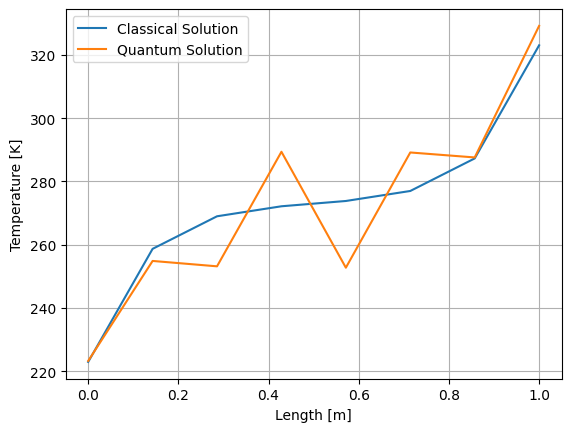

In [60]:
plt.plot(domain,y_classical,label='Classical Solution')
plt.plot(domain,y_quantum,label='Quantum Solution')
plt.xlabel('Length [m]')
plt.ylabel('Temperature [K]')
plt.legend()
plt.grid()
plt.show()

# BONUS

We can also compare the probability results. First, we need to calculate the probabilities of our classical result by reversing the process we used to calculate the quantum amplitudes:

In [61]:
# Normalize to find the classical probabilities
c_norm = y_classical/np.linalg.norm(y_classical)
c_probs = c_norm**2
print('Classical probabilities: ',c_probs)

Classical probabilities:  [0.08265119 0.11125115 0.12026924 0.12311225 0.12462925 0.12752304
 0.13716572 0.17339815]


When we plot our results and compare them to the quantum probabilities, we find:

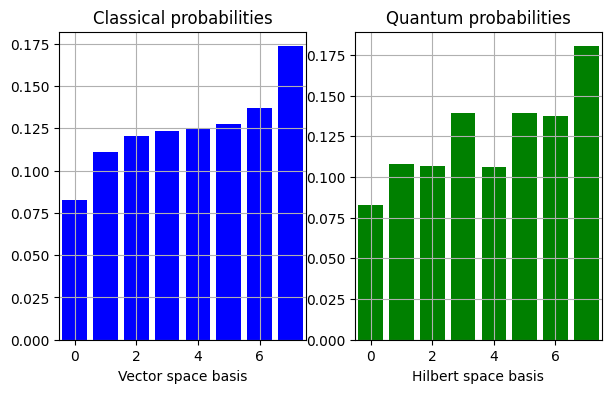

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))

ax1.bar(np.arange(0, len(c_probs)), c_probs, color="blue")
ax1.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax1.set_xlabel("Vector space basis")
ax1.set_title("Classical probabilities")
ax1.grid()

ax2.bar(np.arange(0,len(q_probs)), q_probs, color="green")
ax2.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax2.set_xlabel("Hilbert space basis")
ax2.set_title("Quantum probabilities")
ax2.grid()

plt.show()